In [60]:
%matplotlib inline
import numpy as np
from sympy import *
from mpmath import *
import pylab
from scipy.optimize import minimize

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [1]:
def norm_points(points, high=None, low=None):
    if high is None:
        high = np.max(points)
    if low is None:
        low = np.min(points)
    return Matrix((points-low)/float(high - low))

def cor(x, x_prime, delta):
    def m(i, j):
        return ((x[i, j]-x_prime[i, j])/delta[j])**2
    return exp(-sum(Matrix(x.cols, x.rows, m)))

def cov(x, x_prime, delta, sigma_squared):
    return sigma_squared*cor(x, x_prime, delta)

def pi_star_delta(sigma_hat_sq, n, q, A_inv, A, H):
    return power(sigma_hat_sq, -(n-q)/2.)*power(A.det(), -1/2.)*power((H.T*A_inv*H).det(), -1/2.)

def sigma_hat_sq(n, q, f_D, A_inv, H):
    return (((n-q-2)**-1.)*f_D.T*(A_inv-A_inv*H*((H.T*A_inv*H)**-1)*H.T*A_inv)*f_D)[0, 0]

def sigma_hat_sq_beta(n, q, f_D, A_inv, H_, beta_hat):
    return ((f_D-H_*beta_hat).T*A_inv*(f_D-H_*(beta_hat)))/(n-q-2.)

def A(points, delta):
    def m(i, j):
        return cor(points[:,i], points[:,j], delta)
    a = Matrix(points.cols, points.cols, m)
    return a

def tau(delta):
    return 2*np.log(delta)

def pi_star_tau(tau, n, q, f_D, A_inv, A, H):
    return pi_star_delta(sigma_hat_sq(n, q, f_D, A_inv, H), n, q, A_inv, A, H)

def H(x, h):
    return h(x).T

def beta_hat(H, A_inv, f_D):
    return ((H.T*A_inv*H)**-1)*H.T*A_inv*f_D

def h(x):
    return Matrix(np.vstack((np.ones(len(x)), x)))

def mahalanobis(f_D, m_star, v_star):
    return (f_D - m_star).T*(v_star**-1)*(f_D - m_star)

def se(f_D, m_star, v_star):
    return (f_D - m_star).T / diag(v_star).applyfunc(sqrt)

def make_t(D, delta_hat):
    def f(x):
        def m(i, j):
            return cor(D[:,i], x[:,j], delta_hat)
        a = Matrix(D.cols, x.cols, m)
        return a
    return f

def make_m_star(h, b_hat, A_inv, f_D, t):
    def f(x):
        return h(x).T*b_hat + t(x).T*A_inv*(f_D - H_*b_hat)
    return f

def make_v_star(d_hat_sq, delta_hat, A_inv, h, H_, t):    
    def f(x, x_prime):
        def m(i, j):
            return cor(x[:,i], x_prime[:,j], delta_hat)
        c_x_x_prime = Matrix(x.cols, x_prime.cols, m)
        return d_hat_sq*(c_x_x_prime - t(x).T*A_inv*t(x_prime) + (h(x).T-t(x).T*A_inv*H_)*((H_.T*A_inv*H_)**-1)*((h(x_prime).T-t(x_prime).T*A_inv*H_).T))
    return f

def diag(x):
    def m(i, j):
        return x[i, i]
    a = Matrix(x.cols, 1, m)
    return a

def Trace(x):
    return sum*diag(x)

def fit(n, q, f_D, D, h, start):
    def f(x):
        x = Matrix(map(lambda y: exp(mpf(y)/2.), x))
        a = A(D, x)
        a_inv = a**-1
        return -log(pi_star_tau(x, n, q, f_D, a_inv, a, H(D, h)))
    tau = minimize(f, start, method="nelder-mead", options={'disp':True})['x']
    delta_hat = map(exp, map(lambda x: x/2., map(mpf,tau)))
    return delta_hat

In [87]:
points = np.array([1100,1140,1180,1220,1260,1300])
f_D = Matrix([-48.85,-45.15,-23.78,-8.87,-1.49,4.77])
D = Matrix(norm_points(points)).T
taus = np.linspace(-6, 2)
n = len(points)
p = 1
q = 1 + p
delta_hat = 0.252
D, f_D

(Matrix([[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]]), Matrix([
 [-48.85],
 [-45.15],
 [-23.78],
 [ -8.87],
 [ -1.49],
 [  4.77]]))

In [89]:
As = map(lambda s: A(D, Matrix([exp(s/2.)]).T), taus)
H(D, h), As[0]

IndexError: Index out of range: a[1]

In [64]:
A_invs = map(lambda a: a**-1, As)

In [65]:
ln_pi_tau_star_pi = np.array(map(lambda (t, a_inv, a): log(pi_star_tau(exp(t/2.), n, q, f_D, a_inv, a, H(D, h))), zip(taus, A_invs, As))).flatten()
ln_pi_tau_star_pi

array([mpf('-8.7120065202388748'), mpf('-8.7120055231693598'),
       mpf('-8.7119979989644438'), mpf('-8.7119568453929475'),
       mpf('-8.7117858865790954'), mpf('-8.7112243933430005'),
       mpf('-8.7097152163991449'), mpf('-8.7062957120825288'),
       mpf('-8.6995949998243507'), mpf('-8.6879859514831494'),
       mpf('-8.6698629270425673'), mpf('-8.6439571227721466'),
       mpf('-8.6096070523909418'), mpf('-8.5669603228802469'),
       mpf('-8.5171328647079214'), mpf('-8.4623431058288094'),
       mpf('-8.4059899263244766'), mpf('-8.352618594663797'),
       mpf('-8.307745192578917'), mpf('-8.2775483719627925'),
       mpf('-8.2684441115099467'), mpf('-8.2865455870224132'),
       mpf('-8.3370252762268837'), mpf('-8.4234651685162696'),
       mpf('-8.5473649136403065'), mpf('-8.7079946085844924'),
       mpf('-8.9026789090535186'), mpf('-9.1274292619999038'),
       mpf('-9.3777136085951884'), mpf('-9.6491422112976881'),
       mpf('-9.9379340557393938'), mpf('-10.2411367742083

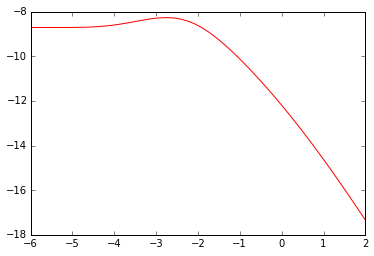

In [66]:
figure()
pylab.plot(taus, ln_pi_tau_star_pi, 'r')
show()

In [67]:
delta_hat = fit(n, q, f_D, D, h, -2.75)
print delta_hat

Optimization terminated successfully.
         Current function value: 8.268213
         Iterations: 12
         Function evaluations: 24
[mpf('0.25205993589271652')]


In [68]:
A_inv = np.matrix(A(D, delta_hat)).getI()
b_hat = beta_hat(H(D, h), A_inv, f_D)
d_hat_sq = sigma_hat_sq(n, q, f_D, A_inv, H(D, h))
H_ = H(D, h)

In [69]:
b_hat, d_hat_sq, sigma_hat_sq_beta(n, q, f_D, A_inv, H(D, h), b_hat)

(Matrix([
 [-47.2952014907982],
 [ 53.7815255538822]]), 93.0185165288469, Matrix([[93.0185165288473]]))

In [70]:
original_points = points
points = np.linspace(1075, 1325, 100)
normed_points = Matrix(norm_points(points, high=1300, low=1100)).T

t = make_t(D, delta_hat)
m_star = make_m_star(h, b_hat, A_inv, f_D, t)
v_star = make_v_star(d_hat_sq, delta_hat, A_inv, h, H_, t)
normed_points.cols

100

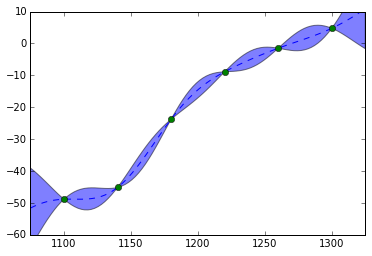

In [71]:
predictions = matrix2numpy(m_star(normed_points), dtype=float).flatten()
sds = matrix2numpy(diag(v_star(normed_points, normed_points)).applyfunc(sqrt)*2, dtype=float).flatten()
predictions, sds
figure()
fill_between(points, predictions + sds, predictions - sds, alpha=0.5)
pylab.plot(points, predictions, '--')
pylab.plot(original_points, matrix2numpy(f_D, dtype=float).flatten(), 'o')
ylim([-60, 10])
xlim([1075, 1325])
show()

In [72]:
validation_points = np.array([1110, 1160, 1250])
D_prime = Matrix(norm_points(validation_points, low=1100, high=1300)).T
print D_prime
f_D_prime = Matrix([[-48.16, -39.63, -3.14]]).T
m_star_D_prime = m_star(D_prime)
print m_star_D_prime
v_star_D_prime = v_star(D_prime, D_prime)
print diag(v_star_D_prime).applyfunc(sqrt)
print se(f_D_prime, m_star_D_prime, v_star_D_prime)

Matrix([[0.0500000000000000, 0.300000000000000, 0.750000000000000]])
Matrix([[-48.8353143068377], [-35.6729779839630], [-3.10907136937750]])
Matrix([[1.37927021269991], [1.33280240664599], [0.974864226574860]])
Matrix([[0.675314306837727, -3.95702201603703, -0.0309286306225003]])*Matrix([
[1.37927021269991],
[1.33280240664599],
[0.97486422657486]])**(-1)


In [73]:
mahalanobis(f_D_prime, m_star_D_prime, v_star_D_prime)

Matrix([[26.6627862710345]])

In [74]:
points = np.array([1100, 1110, 1140, 1160, 1180,1220, 1250,1260,1300])
f_D = Matrix([[-48.85,-48.16, -45.15, -39.63, -23.78,-8.87, -3.14, -1.49,4.77]]).T
D = Matrix(norm_points(points)).T
n = len(points)

In [75]:
delta_hat = fit(n, q, f_D, D, h, -2.75)
print delta_hat

Optimization terminated successfully.
         Current function value: 10.658584
         Iterations: 15
         Function evaluations: 30
[mpf('0.16912900604904935')]


In [76]:
A_inv = np.matrix(A(D, delta_hat)).getI()
b_hat = beta_hat(H(D, h), A_inv, f_D)
d_hat_sq = sigma_hat_sq(n, q, f_D, A_inv, H(D, h))
H_ = H(D, h)
print b_hat, d_hat_sq

Matrix([[-48.6457154367916], [56.4632108836243]]) 49.9993413295219


In [77]:
original_points = points
points = np.linspace(1075, 1325,100)
normed_points = Matrix(norm_points(points, high=1300, low=1100)).T

t = make_t(D, delta_hat)
m_star = make_m_star(h, b_hat, A_inv, f_D, t)
v_star = make_v_star(d_hat_sq, delta_hat, A_inv, h, H_, t)

predictions = matrix2numpy(m_star(normed_points), dtype=float).flatten()
sds = matrix2numpy(diag(v_star(normed_points, normed_points)).applyfunc(sqrt)*2, dtype=float).flatten()

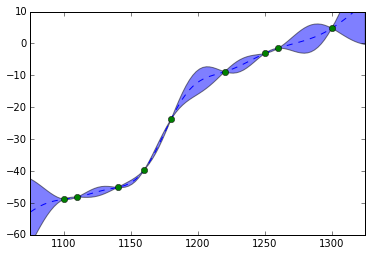

In [78]:
figure()
fill_between(points, predictions + sds, predictions - sds, alpha=0.5)
pylab.plot(points, predictions, '--')
pylab.plot(original_points, matrix2numpy(f_D, dtype=float).flatten(), 'o')
ylim([-60, 10])
xlim([1075, 1325])
show()

In [80]:
validation_points = np.array([1130, 1200, 1270])
D_prime = norm_points(validation_points, low=1100, high=1300).T
print D_prime
f_D_prime = Matrix([[-46.42, -15.45, 0.55]]).T
m_star_D_prime = m_star(D_prime)
print m_star_D_prime
v_star_D_prime = v_star(D_prime, D_prime)
print diag(v_star_D_prime).applyfunc(sqrt)
print se(f_D_prime, m_star_D_prime, v_star_D_prime)

Matrix([[0.150000000000000, 0.500000000000000, 0.850000000000000]])
Matrix([[-45.9889986374434], [-12.1490780138255], [-0.234143542054143]])
Matrix([[0.595688921106910], [1.89344197800128], [0.991001645505514]])
Matrix([[-0.431001362556572, -3.30092198617445, 0.784143542054143]])*Matrix([
[ 0.59568892110691],
[ 1.89344197800128],
[0.991001645505514]])**(-1)


In [81]:
mahalanobis(f_D_prime, m_star_D_prime, v_star_D_prime)

Matrix([[6.20778752514686]])

Optimization terminated successfully.
         Current function value: 10.831993
         Iterations: 16
         Function evaluations: 32
[mpf('0.14505538435262894')]
Matrix([[-50.1799650440613], [58.6406109508480]]) 30.0601337670153


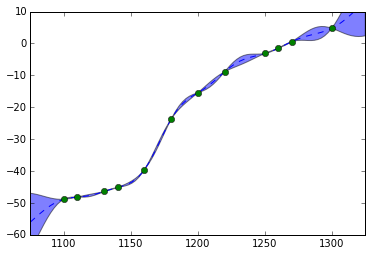

In [85]:
points = np.array([1100, 1110, 1130, 1140, 1160, 1180,1200, 1220, 1250,1260, 1270, 1300])
f_D = Matrix([[-48.85,-48.16, -46.42, -45.15, -39.63, -23.78,-15.45, -8.87, -3.14, -1.49, 0.55, 4.77]]).T
D = norm_points(points).T
n = len(points)

delta_hat = fit(n, q, f_D, D, h, -2.75)
print delta_hat
A_inv = A(D, delta_hat)**-1
b_hat = beta_hat(H(D, h), A_inv, f_D)
d_hat_sq = sigma_hat_sq(n, q, f_D, A_inv, H(D, h))
H_ = H(D, h)
print b_hat, d_hat_sq
original_points = points
points = np.linspace(1075, 1325,100)
normed_points = norm_points(points, high=1300, low=1100).T

t = make_t(D, delta_hat)
m_star = make_m_star(h, b_hat, A_inv, f_D, t)
v_star = make_v_star(d_hat_sq, delta_hat, A_inv, h, H_, t)

predictions = matrix2numpy(m_star(normed_points), dtype=float).flatten()
sds = matrix2numpy(diag(v_star(normed_points, normed_points)).applyfunc(sqrt)*2, dtype=float).flatten()
figure()
fill_between(points, predictions + sds, predictions - sds, alpha=0.5)
pylab.plot(points, predictions, '--')
pylab.plot(original_points, matrix2numpy(f_D, dtype=float).flatten(), 'o')
ylim([-60, 10])
xlim([1075, 1325])
show()